<a href="https://colab.research.google.com/github/krumeto/own_work/blob/master/Twitter_sentiment_analysis%2C_based_on_the_1_6_mil_tweets_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an exercise in Sentiment Analysis with a rarely used dataset - 1.6 mil tweets from 2009 with a negative/positive label. 

I will explore the dataset and compare a couple of model architectures to a rule-based sentiment model - VADER.

In [1]:
!pip install tensorflow==2.0.0
!pip install vaderSentiment

     |████████████████████████████████| 86.3MB 130kB/s 
     |████████████████████████████████| 450kB 37.3MB/s 
     |████████████████████████████████| 3.8MB 32.9MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

     |████████████████████████████████| 133kB 6.4MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import string

import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow version:  2.0.0


In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# The path to the base directory
base_dir = Path("/content/gdrive/My Drive/Twitter dataset")
file_path = base_dir / 'training.1600000.processed.noemoticon.csv'

In [0]:
columns = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(file_path, encoding="ISO-8859-1", names=columns)

## Data exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
target    1600000 non-null int64
ids       1600000 non-null int64
date      1600000 non-null object
flag      1600000 non-null object
user      1600000 non-null object
text      1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df.sample(10)

,target,ids,date,flag,user,text
353718,0,2033033052,Thu Jun 04 12:07:18 PDT 2009,NO_QUERY,Jeranamoe,my dads mad @ me
957835,4,1825559158,Sun May 17 06:07:10 PDT 2009,NO_QUERY,BAZZAKK,"@adamjupp Hey there juppy, karen here, long ti..."
1063641,4,1964505071,Fri May 29 14:20:32 PDT 2009,NO_QUERY,JessyxLin,@therealtiffany omgsh that was in my evan almi...
1443864,4,2062186536,Sat Jun 06 22:33:05 PDT 2009,NO_QUERY,shawny790,@JustGis u have a good night too
291322,0,1995671766,Mon Jun 01 13:51:52 PDT 2009,NO_QUERY,TUTTEAMY,Ahhhhh my ear
590490,0,2217341708,Wed Jun 17 20:43:52 PDT 2009,NO_QUERY,quayisabeauty,Wit my boo chillin...gotta bring home a half g...
134696,0,1836315793,Mon May 18 07:46:40 PDT 2009,NO_QUERY,Rayleigh2012,Tired i got up too early
966255,4,1827676221,Sun May 17 11:12:47 PDT 2009,NO_QUERY,AsMeYo,@BluMorningGlory we have rabbits in our yard t...
603839,0,2221770770,Thu Jun 18 05:58:41 PDT 2009,NO_QUERY,janaebreanna,@StephenDoll hey mister. long time no see. i m...
382801,0,2053070386,Sat Jun 06 03:09:14 PDT 2009,NO_QUERY,Puck_,"Gah, now it seems that gpg doesn't work correc..."


In [8]:
df['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

There are equal number of positive and negative labels.

In [9]:
df['flag'].value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

It appears that the 'flag' column brings no information.

In [10]:
subset = df.sample(5)[['target', 'text']]
for i in range(5):
  print("Tweet:", subset.iloc[i]['text'], "...")
  print("Label:",  " Positive" if subset.iloc[i]['target'] == 4 else " Negative")
  print()

Tweet: On my way to the beach...to think that this time last week I was at Pure  oh well I guess south beach isn't so bad haha ...
Label:  Negative

Tweet: @crittyjoy I will.   I hope to have a chance to read it this week! ...
Label:  Positive

Tweet: Up getting ready for work blah my tuesdays suck  hope ur tuesdays are better ...
Label:  Negative

Tweet: off to the pool with mom and ally. n.weis is there, so this should be fun!  ...
Label:  Positive

Tweet: @caro_k I'm sorry, I didn't check my cell phone after the prayer and found out now about the message. So what's your question?  ...
Label:  Positive



While the positive examples are , well, positive, the negative examples seem less convincingly negative. I will compare them later to the VADER sentiment assessment.

Just for fun, lets see if people tweet more positively on the weekends and negatively throughout the week. If I can, same can be tried with the months (hypothesis is that the people are slightly happier when is warmer and sunny).


In [0]:
df['weekday'] = df['date'].str.split(" ", expand=True)[0]
df['month'] = df['date'].str.split(" ", expand=True)[1]

In [12]:
print(df['weekday'].unique())
print(df['month'].unique())

['Mon' 'Tue' 'Fri' 'Sat' 'Sun' 'Wed' 'Thu']
['Apr' 'May' 'Jun']


OK, I will be able to test the weekdays hypothesis but not "happy months" one.

In [13]:
df.groupby('weekday').mean()['target'].sort_values()

weekday
Thu    0.977149
Wed    1.170713
Tue    1.825106
Fri    1.968031
Sat    2.093590
Mon    2.290950
Sun    2.311201
Name: target, dtype: float64

The average sentiment is 2 (labels for positive is 0 and for negative is 4). People seem to be significantly grumpier on Thursdays and Wednesday and happiest on Sundays. That seems about right. I did not expect the Monday to pop-up in second place.

One possible explanation of the results is that people charge Friday night through Sunday, still draw from that on Mondays and get exhausted throughout the week.

OK, lets add VADER to the dataset. VADER is a rule-based model created by Eric Gilbert and CJ Hutto from Georgia Institute of Technology, created specially for Social Media Sentiment Analysis. More on VADER here: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

In [0]:
sid = SentimentIntensityAnalyzer()
df['naive_sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x))

VADER's analyzer outputs 4 scores - negative, neutral and positive score, as well as a compound one.
Example: {'neg': 0.0, 'neu': 0.326, 'pos': 0.674, 'compound': 0.7351}

The Positive, Negative and Neutral scores represent the proportion of text that falls in these categories. This means our sentence was rated as 67% Positive, 33% Neutral and 0% Negative. Hence all these add up to 1.

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive). In the case above, lexicon ratings for andsupercool are 2.9and respectively1.3. The compound score turns out to be 0.75 , denoting a very high positive sentiment.

In [0]:
df['vader_compound'] = df['naive_sentiment'].apply(lambda x: x['compound'])

In [16]:
df.groupby('target').mean()['vader_compound']

target
0   -0.044132
4    0.326535
Name: vader_compound, dtype: float64

In [17]:
df.groupby('target').std()['vader_compound']

target
0    0.436708
4    0.397785
Name: vader_compound, dtype: float64

**As observed, the positive tweets are assessed as really positive by VADER as well, but the ones labeled as negative seem incosistently labeled.** The negative examples have a mean VADER compound score of just -0.04 which as per VADER's autors is rated as neutral with 0.437 standard deviation. 

This is important to have in mind as the models can be only as good as the data we are training them on.

Lets plot the data to gain more intuition. 

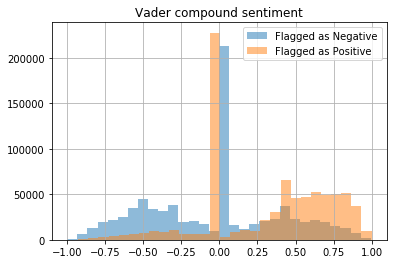

In [18]:
df.groupby('target')['vader_compound'].hist(bins=30, alpha=0.5)
plt.title('Vader compound sentiment')
plt.legend(('Flagged as Negative','Flagged as Positive'))
plt.show()

In [0]:
df['alternative_target'] = pd.cut(df['vader_compound'], bins=[-1.00, -0.25, 0.25, 1], labels=['negative', 'neutral', 'positive'])

In [20]:
len(df[(df['target']=='negative') & (df['alternative_target']=='positive')])

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0

In [21]:
len(df[(df['target']=='positive') & (df['alternative_target']=='negative')])

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0

There are more than 200 000 tweets labeled as negative, which are assessed by VADER as positive (not even neutral, positive). That's 25% of all samples labeled as negative. The oposite is true for ca. 6% of the samples labeled as positive.

## Preprocessing

In [0]:
df['target'] = df['target'].replace({4: 1})

In [0]:
df_after_preprocessing = df.copy()

In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [0]:
df_after_preprocessing['text'] = np.vectorize(remove_pattern)(df_after_preprocessing['text'], "@[\w]*") 

In [0]:
df_after_preprocessing['text'] = df_after_preprocessing['text'].str.replace("\d+", " ")
df_after_preprocessing['text'] = df_after_preprocessing['text'].str.lower()
df_after_preprocessing['text'] = df_after_preprocessing['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [0]:
remove = string.punctuation
remove = remove.replace("!", "") # don't remove !
pattern = r"[{}]".format(remove) # create the pattern
df_after_preprocessing['text'] = df_after_preprocessing['text'].str.replace(pattern, "")

In [0]:
tokenized_text = df_after_preprocessing['text'].apply(lambda x: x.split())

In [0]:
#df_after_preprocessing['target'] = df_after_preprocessing['target'].replace({'negative':0, 'positive':1})

In [32]:
texts = list(df_after_preprocessing['text'])
labels = list(df_after_preprocessing['target'])
print("Number of tweets: ", len(texts))
print("Number of targets: ", len(labels))

Number of tweets:  1600000
Number of targets:  1600000


In [0]:
maxlen = max(df_after_preprocessing['text'].str.len())
training_samples = int(0.8*len(texts))
validation_samples = int(0.1*len(texts))
test_samples = int(0.1*len(texts))
max_words = 10000 

In [34]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 457388 unique tokens.


In [35]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print("Shape of data tensor: ", len(data))
print("Shape of label tensor: ", len(labels))

Shape of data tensor:  1600000
Shape of label tensor:  1600000


In [36]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]
x_test = data[training_samples+validation_samples:]
y_test = labels[training_samples+validation_samples:]

print("Shape train data ", x_train.shape, y_train.shape)
print("Shape validation data ", x_val.shape, y_val.shape)
print("Shape test data ", x_test.shape, y_test.shape)

Shape train data  (1280000, 349) (1280000,)
Shape validation data  (160000, 349) (160000,)
Shape test data  (160000, 349) (160000,)


## 1. Baseline


In [37]:
embedding_dim = 100

from tensorflow.keras.layers import Embedding, Flatten, Dense

model_RNN = keras.models.Sequential()
model_RNN.add(Embedding(max_words,embedding_dim , input_length=maxlen))
model_RNN.add(Flatten())
model_RNN.add(Dense(1, activation='sigmoid'))
model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 349, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 34900)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 34901     
Total params: 1,034,901
Trainable params: 1,034,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
history_rnn = model_RNN.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 1280000 samples, validate on 160000 samples
Epoch 1/5
 838720/1280000 [==================>...........] - ETA: 3:09 - loss: 0.4963 - acc: 0.7626Train on 1280000 samples, validate on 160000 samples
Epoch 1/5
1280000/1280000 [==============================] - 607s 474us/sample - loss: 0.4927 - acc: 0.7654 - val_loss: 0.4831 - val_acc: 0.7736
Epoch 2/5
1280000/1280000 [==============================] - 1573s 1ms/sample - loss: 0.4761 - acc: 0.7771 - val_loss: 0.4835 - val_acc: 0.7736
Epoch 3/5
1280000/1280000 [==============================] - 1200s 938us/sample - loss: 0.4663 - acc: 0.7831 - val_loss: 0.4911 - val_acc: 0.7706
Epoch 4/5
 432480/1280000 [=========>....................] - ETA: 17:25 - loss: 0.4514 - acc: 0.7916Buffered data was truncated after reaching the output size limit.Buffered data was truncated after reaching the output size limit.

In [0]:
def plot_history(history, loss="loss"):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()
 
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

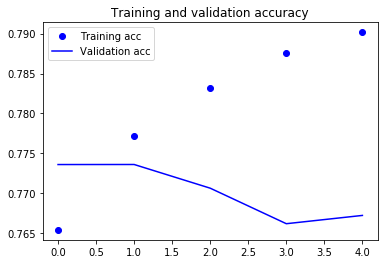

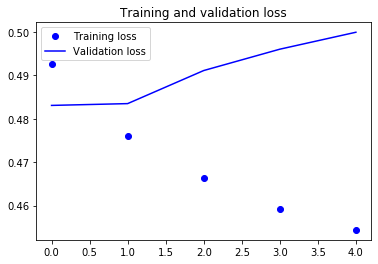

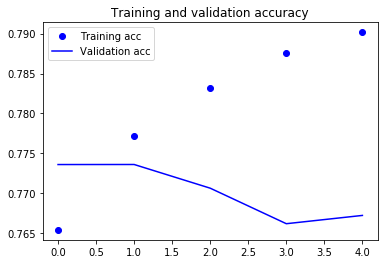

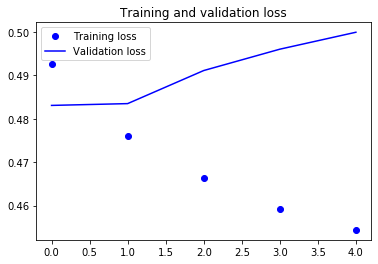

In [40]:
plot_history(history_rnn)

## 2. LSTM model

In [41]:
from tensorflow.keras.layers import LSTM

model_LSTM = keras.models.Sequential()
model_LSTM.add(Embedding(max_words,embedding_dim , input_length=maxlen))
model_LSTM.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))

model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 349, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 349, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
______________________

In [0]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history_LSTM = model_LSTM.fit(x_train[:300_000], y_train[:300_000],
                    epochs=3,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Train on 300000 samples, validate on 160000 samples
Epoch 1/3
107136/300000 [=========>....................] - ETA: 32:23 - loss: 0.4869 - acc: 0.7651

## Next steps:


1.   Try Naive Bayes as a simple ML baseline
2.   Try using only those samples which are labeled equally in the dataset and by VADER, hoping to remove the ambiguous/poorly labeled samples.
3. Try Conv1D network, then Conv1D + LSTM



In [0]:
df_after_preprocessing['text']

In [0]:
original_dataset = df[['target', 'text']]
vader_dataset = df[['alternative_target', 'text']]

In [0]:
original_dataset['text']

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment 
classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.


1.   Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment 
classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.
2.   http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

